In [1]:
# import libraries

import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
from dotenv import load_dotenv

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# connect to Redshift

load_dotenv()
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}")

In [3]:
# Use the read_sql() function to query this table and store the output as a variable

query = """
SELECT ot.*,
        case when sd.description = '?' or sd.description is null then 'Unknown' else sd.description end as description
FROM bootcamp1.online_transactions ot
LEFT JOIN bootcamp1.stock_description sd ON ot.stock_code = sd.stock_code
WHERE ot.customer_id <> '' 
AND ot.stock_code NOT IN ('BANK CHARGES', 'POSTAGE', 'D', 'M', 'CRUK')
AND ot.quantity > 0 """

online_transaction = pd.read_sql(text(query), engine)

In [4]:
# Remove duplicates and fix invoice_date type

online_transaction_cleaned = online_transaction.drop_duplicates(keep='first')
online_transaction_cleaned.invoice_date = pd.to_datetime(online_transaction_cleaned.invoice_date, 
                                                   format = "%Y-%m-%d")

### Top ten most popular geographical locations

In [5]:
online_transaction_cleaned.groupby("country").customer_id.nunique().sort_values(ascending=False).head(10)

country
United Kingdom    3917
Germany             94
France              87
Spain               30
Belgium             25
Switzerland         21
Portugal            19
Italy               14
Finland             12
Austria             11
Name: customer_id, dtype: int64

### Country with the most spend

In [6]:
online_transaction_cleaned["total_price"] = online_transaction_cleaned.price*online_transaction_cleaned.quantity
online_transaction_cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price
0,536365,85123A,6,2010-12-01 08:26:00,2.55,u1785,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,15.30
1,536365,84029E,6,2010-12-01 08:26:00,3.39,u1785,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34
2,536366,22632,6,2010-12-01 08:28:00,1.85,u1785,United Kingdom,HAND WARMER RED POLKA DOT,11.10
3,536368,22914,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,BLUE COAT RACK PARIS FASHION,14.85
4,536367,22749,8,2010-12-01 08:34:00,3.75,u13047,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,30.00


In [7]:
online_transaction_cleaned.groupby(by="country").total_price.sum().sort_values(ascending=False).index[0]

'United Kingdom'

### Invoices across month

In [8]:
online_transaction_cleaned["year"] = online_transaction_cleaned["invoice_date"].dt.year
online_transaction_cleaned["month"] = online_transaction_cleaned["invoice_date"].dt.month
online_transaction_cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price,year,month
0,536365,85123A,6,2010-12-01 08:26:00,2.55,u1785,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,15.30,2010,12
1,536365,84029E,6,2010-12-01 08:26:00,3.39,u1785,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34,2010,12
2,536366,22632,6,2010-12-01 08:28:00,1.85,u1785,United Kingdom,HAND WARMER RED POLKA DOT,11.10,2010,12
3,536368,22914,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,BLUE COAT RACK PARIS FASHION,14.85,2010,12
4,536367,22749,8,2010-12-01 08:34:00,3.75,u13047,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,30.00,2010,12


In [9]:
year_2010 = online_transaction_cleaned.loc[online_transaction_cleaned["year"] == 2010]
year_2010.month.value_counts()

12    26098
Name: month, dtype: int64

In [10]:
year_2011 = online_transaction_cleaned.loc[online_transaction_cleaned["year"] == 2011]
year_2011.month.value_counts()

11    64277
10    49696
9     40439
5     28724
6     27507
8     27368
3     27301
7     27123
4     22758
1     21264
2     19993
12    17319
Name: month, dtype: int64

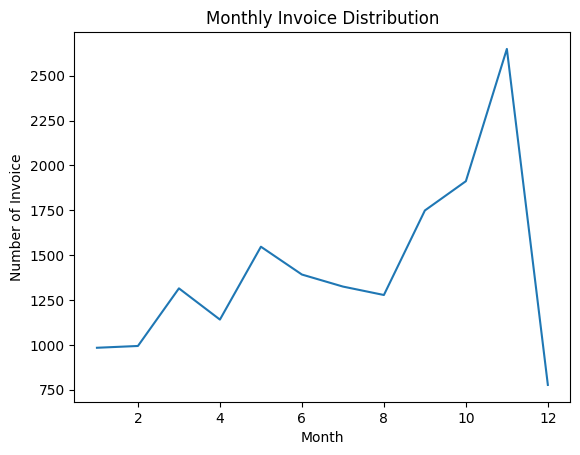

In [11]:
monthly_invoice_distribution = year_2011.groupby(by="month").invoice.nunique()

ax = sns.lineplot(x=monthly_invoice_distribution.index, y=monthly_invoice_distribution.values)

ax.set_title('Monthly Invoice Distribution')
ax.set_xlabel('Month')
ax.set_ylabel("Number of Invoice");

### Week day of the highest number of transaction

In [12]:
year_2011["week_day"] = year_2011["invoice_date"].dt.weekday
year_2011.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price,year,month,week_day
20085,539993,22379,5,2011-01-04 10:00:00,2.10,u13313,United Kingdom,RECYCLING BAG RETROSPOT,10.50,2011,1,1
20086,539993,22961,12,2011-01-04 10:00:00,1.45,u13313,United Kingdom,JAM MAKING SET PRINTED,17.40,2011,1,1
20087,539993,22303,6,2011-01-04 10:00:00,2.55,u13313,United Kingdom,COFFEE MUG APPLES DESIGN,15.30,2011,1,1
20088,539993,22458,8,2011-01-04 10:00:00,2.55,u13313,United Kingdom,CAST IRON HOOK GARDEN FORK,20.40,2011,1,1
20089,540001,22151,48,2011-01-04 10:22:00,0.42,u18097,United Kingdom,PLACE SETTING WHITE HEART,20.16,2011,1,1


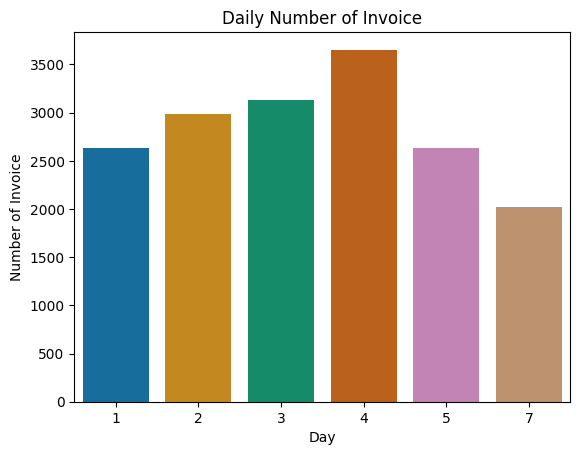

In [13]:
week_day_invoice_count = year_2011.groupby(by="week_day").invoice.nunique().rename(lambda x: x+1)

ax = sns.barplot(x=week_day_invoice_count.index, y=week_day_invoice_count.values, palette="colorblind")
ax.set_title('Daily Number of Invoice')
ax.set_xlabel('Day')
ax.set_ylabel("Number of Invoice");

### Identify customers that have spent more than the average user

In [14]:
average_price_per_user = online_transaction_cleaned.groupby("customer_id").total_price.sum().mean()

In [15]:
s = (online_transaction_cleaned.groupby("customer_id").total_price.sum() > 
    average_price_per_user)
user_id_more_than_average = list(s[s].index)

In [16]:
online_transaction_cleaned[online_transaction_cleaned.customer_id.isin(user_id_more_than_average)]

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price,year,month
0,536365,85123A,6,2010-12-01 08:26:00,2.55,u1785,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,15.30,2010,12
1,536365,84029E,6,2010-12-01 08:26:00,3.39,u1785,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34,2010,12
2,536366,22632,6,2010-12-01 08:28:00,1.85,u1785,United Kingdom,HAND WARMER RED POLKA DOT,11.10,2010,12
3,536368,22914,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,BLUE COAT RACK PARIS FASHION,14.85,2010,12
4,536367,22749,8,2010-12-01 08:34:00,3.75,u13047,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,30.00,2010,12
...,...,...,...,...,...,...,...,...,...,...,...
405126,581585,84879,16,2011-12-09 12:31:00,1.69,u15804,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,27.04,2011,12
405127,581585,22726,8,2011-12-09 12:31:00,3.75,u15804,United Kingdom,ALARM CLOCK BAKELIKE GREEN,30.00,2011,12
405128,581585,84692,25,2011-12-09 12:31:00,0.42,u15804,United Kingdom,BOX OF 24 COCKTAIL PARASOLS,10.50,2011,12
405129,581585,23328,4,2011-12-09 12:31:00,3.75,u15804,United Kingdom,SET 6 SCHOOL MILK BOTTLES IN CRATE,15.00,2011,12


### Top 10 customer with the most purchase

In [17]:
online_transaction_cleaned.groupby("customer_id").invoice.nunique().sort_values(ascending=False).head(10)

customer_id
u12748    206
u14911    199
u17841    124
u13089     97
u15311     91
u14606     91
u12971     86
u14646     74
u16029     63
u13408     62
Name: invoice, dtype: int64

### Top 10 item the most sold

In [18]:
online_transaction_cleaned.groupby("description").quantity.sum().sort_values(ascending=False).head(10)

description
Unknown                               99299
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
POPCORN HOLDER                        49160
JUMBO BAG RED RETROSPOT               46078
CREAM HANGING HEART T-LIGHT HOLDER    36763
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
RABBIT NIGHT LIGHT                    27153
Name: quantity, dtype: int64

### Customers have spent the least amount

In [19]:
online_transaction_cleaned.groupby("customer_id").total_price.sum().sort_values().head(10)

customer_id
u13256     0.00
u16738     3.75
u16454     5.90
u14792     6.20
u17956    12.75
u16878    13.30
u13307    15.00
u17763    15.00
u16093    17.00
u16953    20.80
Name: total_price, dtype: float64